In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from umap import UMAP

%matplotlib inline

# Exploration

We filtered on the previous dataset only movies where we have ratings and inforamtion about actors. Now we can use those lighter dataset and combine them is order to be able to do a clustering of movies by similarity. The final idea is to got 3D position for every movies, all similar movies must be close and differents one must be as far as possible. L'et's now explore our datasets. 

The main one contains all movies with some information, the seocnd one liste main actor/producer/... for every movies and the last one gives inforamtions about actor/producer/... .

In [2]:
title = pd.read_csv("../datas/prepared/title.basics.csv", index_col=0, encoding="ISO-8859-1")
name = pd.read_csv("../datas/prepared/name.csv", index_col=0, encoding="ISO-8859-1")
principal = pd.read_csv("../datas/prepared/principal.csv", index_col=0, encoding="ISO-8859-1")

In [19]:
title.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200692 entries, tt0000335 to tt8156742
Data columns (total 9 columns):
primaryTitle      200692 non-null object
originalTitle     200691 non-null object
startYear         200691 non-null float64
runtimeMinutes    200692 non-null int64
genres            186874 non-null object
averageRating     200692 non-null float64
numVotes          200692 non-null int64
directors         200692 non-null object
writers           200692 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 15.3+ MB


In [20]:
title.head()

,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
tconst,,,,,,,,,
tt0000335,Soldiers of the Cross,Soldiers of the Cross,1900.0,65535,"Biography,Drama",6.2,32,"nm0675140,nm0095714",\N
tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906.0,70,"Biography,Crime,Drama",6.3,439,nm0846879,nm0846879
tt0000615,Robbery Under Arms,Robbery Under Arms,1907.0,65535,Drama,5.1,12,nm0533958,"nm0092809,nm0533958"
tt0000630,Hamlet,Amleto,1908.0,65535,Drama,2.9,8,nm0143333,nm0000636
tt0000675,Don Quijote,Don Quijote,1908.0,65535,Drama,4.7,7,nm0194088,nm0148859


# Votes

for every movies, we know the number of votes and the average rating. We can first explore the repartition of those variable and this may help finding a proper way to do a modelisation.

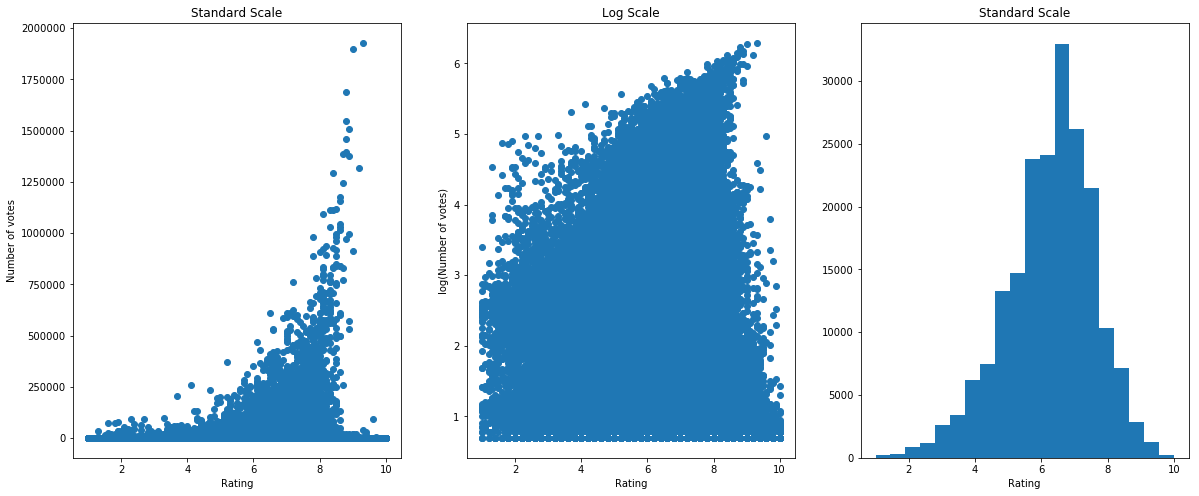

In [21]:
plt.figure(figsize=(20,8))

plt.subplot(1, 3, 1)
plt.scatter(title.averageRating, title.numVotes )
plt.title("Standard Scale")
plt.xlabel("Rating")
plt.ylabel("Number of votes")

plt.subplot(1, 3, 2)
plt.scatter(title.averageRating, np.log10(title.numVotes) )
plt.title("Log Scale")
plt.xlabel("Rating")
plt.ylabel("log(Number of votes)")

plt.subplot(1, 3, 3)
plt.hist(title.averageRating, bins=20 )
plt.title("Standard Scale")
plt.xlabel("Rating")

plt.show()

We can see that movies with a lot of votes often reach a limit at 8.5. In term of number of votes, we can see that there is a huge unbalance between both variable sot the log10 for the number of vote may help having movies more balanced.  

# Actors

### Merge and grouping

Let's keep only actors on the list of people working on our list of movies. We can after get all ratings for every movie of every actors

In [22]:
actors = principal[principal.category.str.startswith("act")][["nconst", "category"]]

In [23]:
actors = pd.merge(actors.reset_index(), title[['averageRating','numVotes']].reset_index(), on="tconst", how='inner')

In [24]:
sex = {"actress" : 0, "actor" : 1}
actors["category"] = actors["category"].apply(lambda x: sex[x])

We can now group the dataset by actor and keep main values

In [25]:
actors = actors.groupby("nconst").agg({
    "tconst" : "nunique",
    "category" : "max",  # it will constant for all movies
    "averageRating" : ["min", "median", "max", "mean", "std"],
    "numVotes" : ["min", "median", "max", "mean", "std"]
})

actors.fillna(0, inplace=True)

actors.columns = ["num_movies", "sex", "rating_min", "rating_median", "rating_max", "rating_mean", "rating_std", "votes_min", "votes_median", "votes_max", "votes_mean", "votes_std"]

In [26]:
actors.head(5)

,num_movies,sex,rating_min,rating_median,rating_max,rating_mean,rating_std,votes_min,votes_median,votes_max,votes_mean,votes_std
nconst,,,,,,,,,,,,
nm0000001,36,1,5.1,6.90,7.8,6.863889,0.609052,80,2452.0,21863,4030.583333,4656.559548
nm0000002,37,0,2.2,6.60,8.0,6.570270,1.046917,65,2314.0,118611,11794.135135,23443.866100
nm0000003,36,0,4.5,5.75,7.7,5.919444,0.721831,27,380.5,22849,1513.222222,3885.208258
nm0000004,7,1,5.2,6.10,7.9,6.357143,1.017934,181,6563.0,157351,42796.857143,61264.160419
nm0000005,2,1,6.3,6.75,7.2,6.750000,0.636396,38,38.5,39,38.500000,0.707107


In [27]:
actors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 287018 entries, nm0000001 to nm9711039
Data columns (total 12 columns):
num_movies       287018 non-null int64
sex              287018 non-null int64
rating_min       287018 non-null float64
rating_median    287018 non-null float64
rating_max       287018 non-null float64
rating_mean      287018 non-null float64
rating_std       287018 non-null float64
votes_min        287018 non-null int64
votes_median     287018 non-null float64
votes_max        287018 non-null int64
votes_mean       287018 non-null float64
votes_std        287018 non-null float64
dtypes: float64(8), int64(4)
memory usage: 28.5+ MB


We can merge with information about every actors now

In [28]:
actors = pd.merge(actors.reset_index(), name[["primaryName", "birthYear", "deathYear", "primaryProfession"]].reset_index(), on="nconst", how='left')

In [29]:
actors.head()

,nconst,num_movies,sex,rating_min,rating_median,rating_max,rating_mean,rating_std,votes_min,votes_median,votes_max,votes_mean,votes_std,primaryName,birthYear,deathYear,primaryProfession
0,nm0000001,36,1,5.1,6.90,7.8,6.863889,0.609052,80,2452.0,21863,4030.583333,4656.559548,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous"
1,nm0000002,37,0,2.2,6.60,8.0,6.570270,1.046917,65,2314.0,118611,11794.135135,23443.866100,Lauren Bacall,1924,2014,"actress,soundtrack"
2,nm0000003,36,0,4.5,5.75,7.7,5.919444,0.721831,27,380.5,22849,1513.222222,3885.208258,Brigitte Bardot,1934,\N,"actress,soundtrack,producer"
3,nm0000004,7,1,5.2,6.10,7.9,6.357143,1.017934,181,6563.0,157351,42796.857143,61264.160419,John Belushi,1949,1982,"actor,writer,soundtrack"
4,nm0000005,2,1,6.3,6.75,7.2,6.750000,0.636396,38,38.5,39,38.500000,0.707107,Ingmar Bergman,1918,2007,"writer,director,actor"


In [14]:
actors = actors.replace('\\N', np.NaN)
actors.to_csv("../datas/prepared/actors.csv", index=False)

### Professions of actors

We can imagine that the prefession impact their quality of play and also the note. We can now try to handle this by using a Manifold algorithm with the Hamming Distance.

In [30]:
profession = actors["primaryProfession"].str.get_dummies(sep=",").astype(np.uint8)

In [31]:
profession.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287018 entries, 0 to 287017
Data columns (total 37 columns):
actor                        287018 non-null uint8
actress                      287018 non-null uint8
animation_department         287018 non-null uint8
art_department               287018 non-null uint8
art_director                 287018 non-null uint8
assistant                    287018 non-null uint8
assistant_director           287018 non-null uint8
camera_department            287018 non-null uint8
casting_department           287018 non-null uint8
casting_director             287018 non-null uint8
cinematographer              287018 non-null uint8
composer                     287018 non-null uint8
costume_department           287018 non-null uint8
costume_designer             287018 non-null uint8
director                     287018 non-null uint8
editor                       287018 non-null uint8
editorial_department         287018 non-null uint8
executive             

There is plenty of profession and a lot of them have only a few number of people. Before to keep only main section, we can merge some group together likle visual_effects and special_effects which are related to the same work

In [32]:
profession["sound_department"] = profession[["sound_department", "soundtrack", "music_department"]].max(axis=1)
profession["actor"] = profession[["actor", "actress"]].max(axis=1)
profession["animation_department"] = profession[["animation_department", "special_effects", "visual_effects"]].max(axis=1)
profession["art_department"] = profession[["art_department", "art_director", "set_decorator"]].max(axis=1)
profession["editorial_department"] = profession[["editorial_department", "editor", "executive"]].max(axis=1)
profession["assistant"] = profession[["assistant", "assistant_director"]].max(axis=1)
profession["casting_department"] = profession[["casting_department", "casting_director", "publicist", "talent_agent"]].max(axis=1)
profession["camera_department"] = profession[["camera_department", "cinematographer"]].max(axis=1)
profession["director"] = profession[["director", "composer"]].max(axis=1)
profession["costume_department"] = profession[["costume_department", "costume_designer"]].max(axis=1)
profession["production"] = profession[["production_manager", "producer", "production_designer"]].max(axis=1)

profession.drop(["soundtrack", "music_department", "actress", "special_effects", "visual_effects", "art_director", 
                 "set_decorator", "editor", "executive", "assistant_director",  "casting_director", "publicist", 
                 "talent_agent", "cinematographer", "miscellaneous", "composer", "costume_designer", "location_management", 
                 "transportation_department", "production_manager", "producer", "production_designer", "legal"], axis=1, inplace=True)

In [33]:
profession.drop(["actor"], axis=1, inplace=True)  # all are actor as we filter by actor on movies
actors.drop(["primaryProfession"], axis=1, inplace=True)

Let's keep only the main groups

In [39]:
cols = []
for prof, count in zip(profession.columns, profession.as_matrix().sum(axis=0)):
    if count > 3500:
        cols.append(prof)
        print(prof, count)
profession = profession[cols]
actors = pd.concat([actors, profession[cols]], axis=1)

assistant 3968
camera_department 5534
director 26012
sound_department 22038
stunts 3916
writer 32647
production 31145


We have a lot of missing information on birth/death so we will forget it. Anyway, we will have date of release of the movie.

In [40]:
actors.drop(["birthYear", "deathYear"], axis=1, inplace=True)

In [41]:
actors.head()

,nconst,num_movies,sex,rating_min,rating_median,rating_max,rating_mean,rating_std,votes_min,votes_median,...,votes_mean,votes_std,primaryName,assistant,camera_department,director,sound_department,stunts,writer,production
0,nm0000001,36,1,5.1,6.90,7.8,6.863889,0.609052,80,2452.0,...,4030.583333,4656.559548,Fred Astaire,0,0,0,1,0,0,0
1,nm0000002,37,0,2.2,6.60,8.0,6.570270,1.046917,65,2314.0,...,11794.135135,23443.866100,Lauren Bacall,0,0,0,1,0,0,0
2,nm0000003,36,0,4.5,5.75,7.7,5.919444,0.721831,27,380.5,...,1513.222222,3885.208258,Brigitte Bardot,0,0,0,1,0,0,1
3,nm0000004,7,1,5.2,6.10,7.9,6.357143,1.017934,181,6563.0,...,42796.857143,61264.160419,John Belushi,0,0,0,1,0,1,0
4,nm0000005,2,1,6.3,6.75,7.2,6.750000,0.636396,38,38.5,...,38.500000,0.707107,Ingmar Bergman,0,0,1,0,0,1,0


In [43]:
actors.to_csv("../datas/prepared/actors.csv", index=False)

### Clustering of actors

In [204]:
for col in actors:
    if actors[col].dtype != "object":
        print(col, actors[col].dtype)

num_movies int64
sex int64
rating_min float64
rating_median float64
rating_max float64
rating_mean float64
rating_std float64
votes_min int64
votes_median float64
votes_max int64
votes_mean float64
votes_std float64
animation_department uint8
art_department uint8
assistant uint8
camera_department uint8
casting_department uint8
costume_department uint8
director uint8
editorial_department uint8
make_up_department uint8
manager uint8
sound_department uint8
stunts uint8
writer uint8
production uint8


#### Votes and number of movies

As we did for main notes on movies, we can also look note the repartition of datas for every actor and maybe find a good pre-processing to apply.

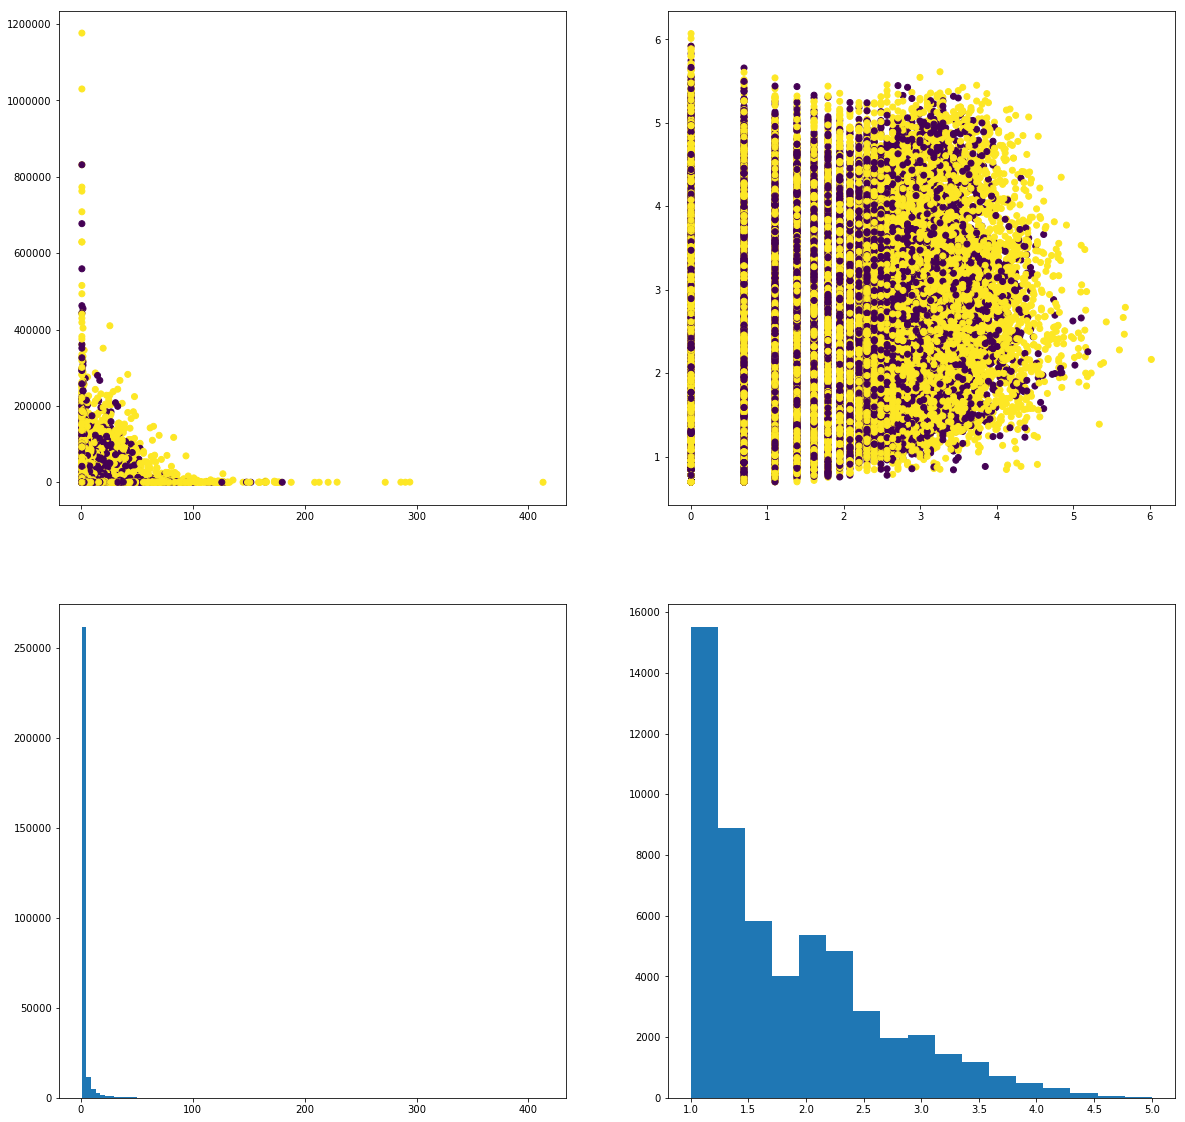

In [224]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.scatter(actors.num_movies, actors.votes_mean, c=actors.sex)

plt.subplot(2, 2, 2)
plt.scatter(np.log(actors.num_movies), np.log10(actors.votes_mean), c=actors.sex)

plt.subplot(2, 2, 3)
plt.hist(actors.num_movies, bins=100 )

plt.subplot(2, 2, 4)
plt.hist(np.log(actors.num_movies), bins=17, range=(1, 5))

plt.show()

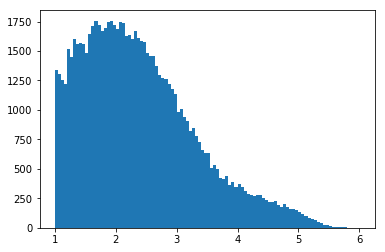

In [262]:
plt.hist(np.log10(actors.votes_std+1), bins=100, range= (1, 6))
plt.show()

Again for number of movie and number of vote, we have a large scale. Using a log will help to not pack all moviesclose to 0 for example.

#### rating of movies

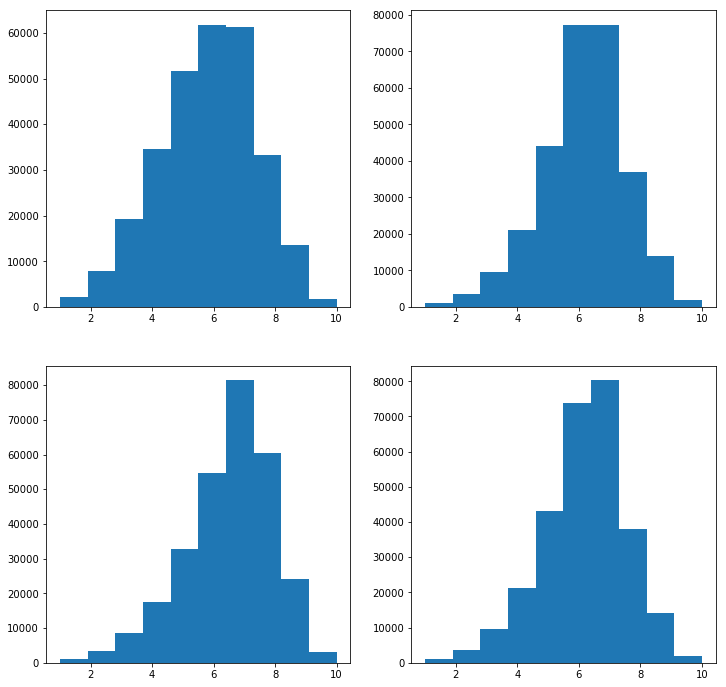

In [255]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
plt.hist(actors.rating_min, bins=10, range=(1, 10))

plt.subplot(2, 2, 2)
plt.hist(actors.rating_mean, bins=10, range=(1, 10))

plt.subplot(2, 2, 3)
plt.hist(actors.rating_max, bins=10, range=(1, 10))

plt.subplot(2, 2, 4)
plt.hist(actors.rating_median, bins=10, range=(1, 10))

plt.show()

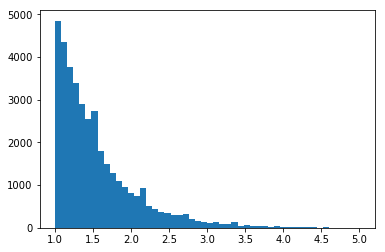

In [254]:
plt.hist(actors.rating_std, bins=50, range= (1, 5))
plt.show()

The rating being limited between 0 and 10, we don't need a log scaling. 

### Dimensions reduction

Now, we will use a Manifold Algorithm to place in a smaller dimensions actors by profession only. The distance to use in such condition if the Hamming Distance. Nevertheless, algorithms need to compute the pairwise distance matrix and with 287k actor, this will be a 287k x 287k matrix and won't be store in memory. So we will remove actors with only 1 movie and with less than 5000 votes in max (means that the actor never player on a movie where there is more 5000 than votes)

In [53]:
actors = actors[actors.num_movies > 1]
actors = actors[actors.votes_max > 5000]
actors=actors.reset_index(drop=True)

In [54]:
actors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12892 entries, 0 to 12891
Data columns (total 21 columns):
nconst               12892 non-null object
num_movies           12892 non-null int64
sex                  12892 non-null int64
rating_min           12892 non-null float64
rating_median        12892 non-null float64
rating_max           12892 non-null float64
rating_mean          12892 non-null float64
rating_std           12892 non-null float64
votes_min            12892 non-null int64
votes_median         12892 non-null float64
votes_max            12892 non-null int64
votes_mean           12892 non-null float64
votes_std            12892 non-null float64
primaryName          12892 non-null object
assistant            12892 non-null uint8
camera_department    12892 non-null uint8
director             12892 non-null uint8
sound_department     12892 non-null uint8
stunts               12892 non-null uint8
writer               12892 non-null uint8
production           12892 non-nu

In [61]:
X = actors[actors.columns[-7:]]

model = UMAP(metric="hamming")
pos = model.fit_transform(X)

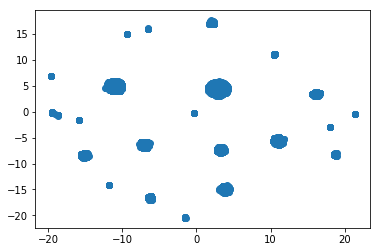

In [63]:
plt.scatter(pos[:,0], pos[:,1])
plt.show()

We can see clear clusters on this result. Nevertheless as there is no ordering, we won't use a clustering algorithm but replace profession by the position in space.

### Final preparation

We will also skip the name and place the nconst as index. We now have a fully numeric dataset we can scale and do the clustering on it.

In [64]:
prof_pos = pd.DataFrame(pos)
prof_pos.columns = ["X", "Y"]

In [65]:
final_actor = pd.concat([actors[actors.columns[0:13]], prof_pos], axis=1).set_index("nconst")

In [66]:
final_actor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12892 entries, nm0000001 to nm9260309
Data columns (total 14 columns):
num_movies       12892 non-null int64
sex              12892 non-null int64
rating_min       12892 non-null float64
rating_median    12892 non-null float64
rating_max       12892 non-null float64
rating_mean      12892 non-null float64
rating_std       12892 non-null float64
votes_min        12892 non-null int64
votes_median     12892 non-null float64
votes_max        12892 non-null int64
votes_mean       12892 non-null float64
votes_std        12892 non-null float64
X                12892 non-null float64
Y                12892 non-null float64
dtypes: float64(10), int64(4)
memory usage: 1.5+ MB


In [67]:
final_actor.to_csv("../datas/prepared/final_actor.csv", index=True)

#### Scaling

We looked previously on data repartition, we can now apply scaling on it.

In [154]:
final_actor = pd.read_csv("../datas/prepared/final_actor.csv", index_col = 0)

In [155]:
final_actor.head()

,num_movies,sex,rating_min,rating_median,rating_max,rating_mean,rating_std,votes_min,votes_median,votes_max,votes_mean,votes_std,X,Y
nconst,,,,,,,,,,,,,,
nm0000001,36,1,5.1,6.90,7.8,6.863889,0.609052,80,2452.0,21863,4030.583333,4656.559548,-11.174329,5.372038
nm0000002,37,0,2.2,6.60,8.0,6.570270,1.046917,65,2314.0,118611,11794.135135,23443.866100,-10.692359,5.192381
nm0000003,36,0,4.5,5.75,7.7,5.919444,0.721831,27,380.5,22849,1513.222222,3885.208258,11.289552,-5.623278
nm0000004,7,1,5.2,6.10,7.9,6.357143,1.017934,181,6563.0,157351,42796.857143,61264.160419,16.046571,3.320192
nm0000006,42,0,5.1,6.80,8.5,6.833333,0.709746,33,1641.5,439965,17208.214286,68451.451296,11.741944,-5.273099


In [156]:
final_actor["num_movies"] = MinMaxScaler().fit_transform(final_actor[["num_movies"]])

final_actor["rating_min"] = StandardScaler().fit_transform(final_actor[["rating_min"]])
final_actor["rating_median"] = StandardScaler().fit_transform(final_actor[["rating_median"]])
final_actor["rating_max"] = StandardScaler().fit_transform(final_actor[["rating_max"]])
final_actor["rating_mean"] = StandardScaler().fit_transform(final_actor[["rating_mean"]])
final_actor["rating_std"] = StandardScaler().fit_transform(final_actor[["rating_std"]])

final_actor["votes_min"] = StandardScaler().fit_transform(final_actor[["votes_min"]])
final_actor["votes_median"] = StandardScaler().fit_transform(final_actor[["votes_median"]])
final_actor["votes_max"] = StandardScaler().fit_transform(final_actor[["votes_max"]])
final_actor["votes_mean"] = StandardScaler().fit_transform(final_actor[["votes_mean"]])
final_actor["votes_std"] = StandardScaler().fit_transform(final_actor[["votes_std"]])

final_actor["X"] = MinMaxScaler().fit_transform(final_actor[["X"]])
final_actor["Y"] = MinMaxScaler().fit_transform(final_actor[["Y"]])

In [157]:
final_actor.head()

,num_movies,sex,rating_min,rating_median,rating_max,rating_mean,rating_std,votes_min,votes_median,votes_max,votes_mean,votes_std,X,Y
nconst,,,,,,,,,,,,,,
nm0000001,0.082725,1,0.435779,0.996423,0.398766,1.072976,-0.847978,-0.110520,-0.183112,-0.348560,-0.365251,-0.440758,0.206884,0.678415
nm0000002,0.085158,0,-1.968150,0.589289,0.644529,0.647351,0.130918,-0.113877,-0.190028,0.244950,-0.096057,-0.028583,0.218627,0.673700
nm0000003,0.082725,0,-0.061585,-0.564256,0.275884,-0.296078,-0.595849,-0.122381,-0.286934,-0.342511,-0.452538,-0.457681,0.754201,0.389852
nm0000004,0.012165,1,0.518673,-0.089267,0.521647,0.338404,0.066123,-0.087917,0.022930,0.482604,0.978934,0.801156,0.870102,0.624566
nm0000006,0.097324,0,0.435779,0.860711,1.258939,1.028683,-0.622865,-0.121039,-0.223733,2.216325,0.091671,0.958837,0.765223,0.399042


#### Clustering

In [163]:
# X = final_actor.drop(["rating_std", "votes_std"], axis=1)
X = final_actor

In [147]:
score = []
for n_clusters in range(2, 50, 2):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    score.append(silhouette_avg)

KeyboardInterrupt: 

C:\python36\envs\machine_learning\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


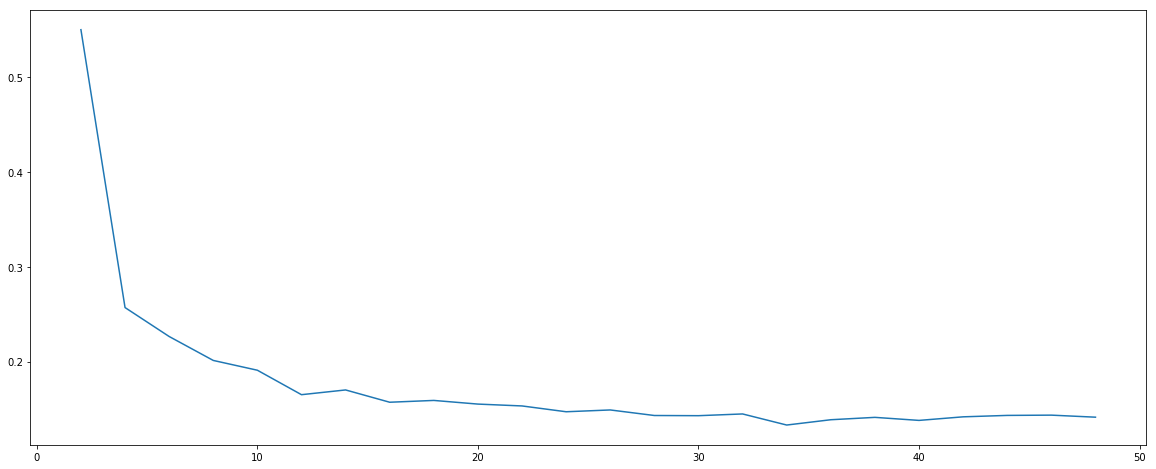

In [75]:
x = list(range(2, 50 , 2))
plt.figure(figsize=(20, 8))
plt.plot(x, score)
plt.legend()
plt.show()

In [164]:
kmeans = KMeans(init='k-means++', n_clusters = 10, n_init=30)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [165]:
model = UMAP(metric="euclidean", n_neighbors=20)
pos = model.fit_transform(X)

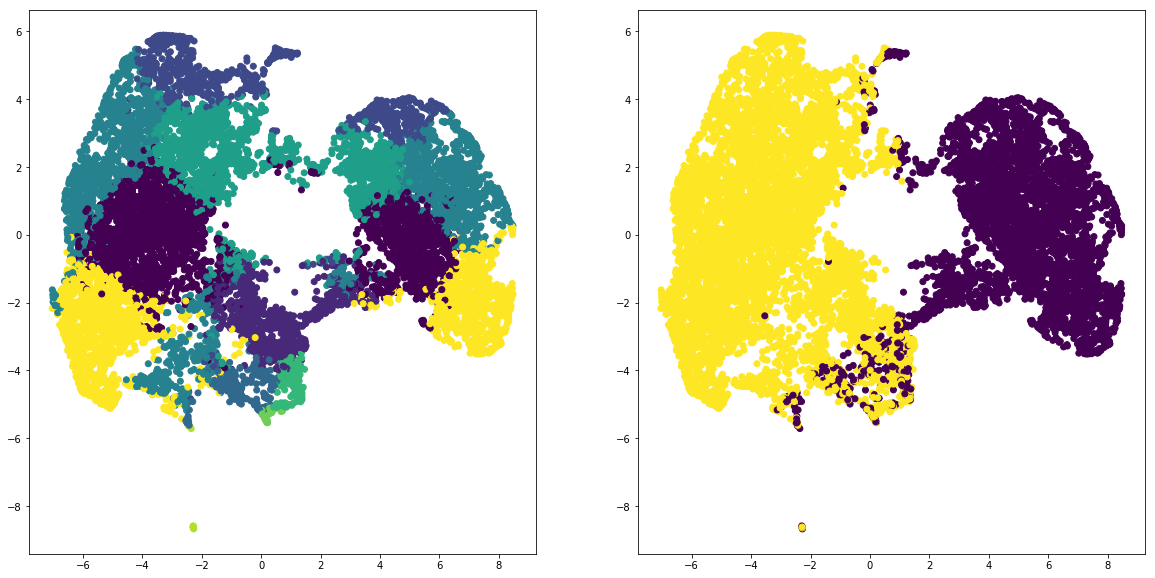

In [166]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.scatter(pos[:,0], pos[:,1], c=clusters)

plt.subplot(1, 2, 2)
plt.scatter(pos[:,0], pos[:,1], c=final_actor.sex)

plt.show()

Let's aggregate the cluster info to the dataset without scaling.

In [167]:
final_actor = pd.read_csv("../datas/prepared/final_actor.csv", index_col = 0)
final_actor["clusters"] = clusters
final_actor.to_csv("../datas/prepared/final_actor_with_clusters.csv", index=True)

### Analysis

In order to validate the clustering we should check that cluster correspond to real features.

In [168]:
final_actor.head()

,num_movies,sex,rating_min,rating_median,rating_max,rating_mean,rating_std,votes_min,votes_median,votes_max,votes_mean,votes_std,X,Y,clusters
nconst,,,,,,,,,,,,,,,
nm0000001,36,1,5.1,6.90,7.8,6.863889,0.609052,80,2452.0,21863,4030.583333,4656.559548,-11.174329,5.372038,9
nm0000002,37,0,2.2,6.60,8.0,6.570270,1.046917,65,2314.0,118611,11794.135135,23443.866100,-10.692359,5.192381,0
nm0000003,36,0,4.5,5.75,7.7,5.919444,0.721831,27,380.5,22849,1513.222222,3885.208258,11.289552,-5.623278,4
nm0000004,7,1,5.2,6.10,7.9,6.357143,1.017934,181,6563.0,157351,42796.857143,61264.160419,16.046571,3.320192,1
nm0000006,42,0,5.1,6.80,8.5,6.833333,0.709746,33,1641.5,439965,17208.214286,68451.451296,11.741944,-5.273099,1


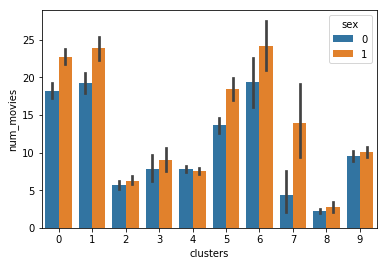

In [170]:
sns.barplot(x="clusters", y="num_movies", hue="sex", data=final_actor)
plt.show()

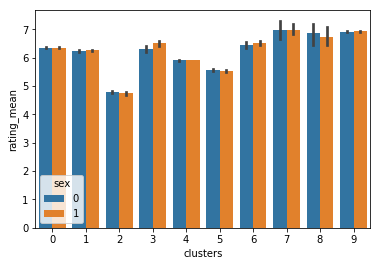

In [171]:
sns.barplot(x="clusters", y="rating_mean", hue="sex", data=final_actor)
plt.show()

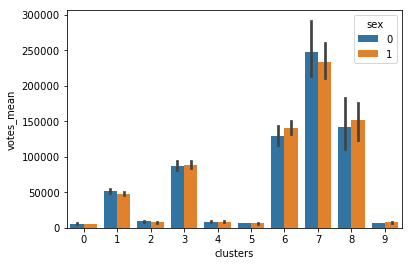

In [172]:
sns.barplot(x="clusters", y="votes_mean", hue="sex", data=final_actor)
plt.show()

Just to analyse content of every cluster, we will get convert the profession to clusters. We had 23 groups distinct.

In [173]:
kmeans = KMeans(init='k-means++', n_clusters = 15, n_init=30)
kmeans.fit(final_actor[["X", "Y"]])
clusters_prof = kmeans.predict(final_actor[["X", "Y"]])

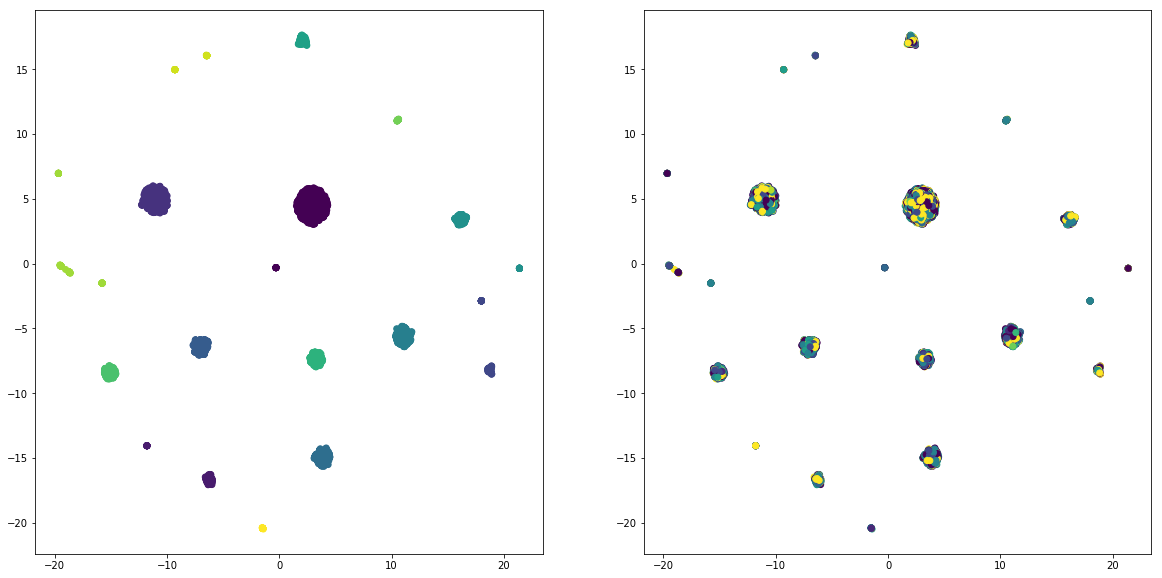

In [174]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.scatter(final_actor.X, final_actor.Y, c=clusters_prof)

plt.subplot(1, 2, 2)
plt.scatter(final_actor.X, final_actor.Y, c=clusters)

plt.show()

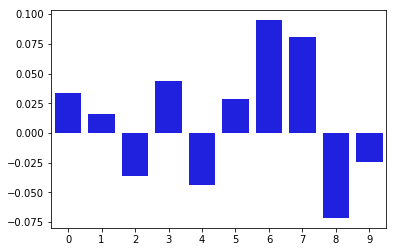

In [175]:
sex_mean = final_actor.sex.values.mean()
variation_sex = []
for i in range(10):
    variation_sex.append(final_actor.sex.values[np.where(clusters == i)].mean() - sex_mean)
    
sns.barplot(y=variation_sex, x=list(range(10)), label="Total", color="b")
plt.show()

We can see that the clustering is not really impacted by the sex. In the worst case, we have 5% variation with the classic repartition male/female. We can also see that there is some clusters which group all known actors with lot of votes. In term of note, there is a small variation but we also saw that the note is often between 6 and 8. This clustering is quite good for now. Let's do the same on producer. This part will be lightweigted as it's the same thing

# Directors

I won't also take a look at prefession in that case because we can assume that a writer/director is legitimate. To produce a movie, you need experience and funds you can only have if are known

In [177]:
director = principal[principal.category == "director"]

In [179]:
director = pd.merge(director.reset_index(), title[['averageRating','numVotes']].reset_index(), on="tconst", how='inner')

In [181]:
director = director.groupby("nconst").agg({
    "tconst" : "nunique",
    "averageRating" : ["min", "median", "max", "mean", "std"],
    "numVotes" : ["min", "median", "max", "mean", "std"]
})

director.fillna(0, inplace=True)
director.columns = ["num_movies", "rating_min", "rating_median", "rating_max", "rating_mean", "rating_std", "votes_min", "votes_median", "votes_max", "votes_mean", "votes_std"]

In [198]:
director = director[director.num_movies>1]
director = director[director.votes_max>200]

In [202]:
director.to_csv("../datas/prepared/final_director.csv", index=True)

In [3]:
director = pd.read_csv("../datas/prepared/final_director.csv", index_col = 0)

In [5]:
director["num_movies"] = MinMaxScaler().fit_transform(director[["num_movies"]])

director["rating_min"] = StandardScaler().fit_transform(director[["rating_min"]])
director["rating_median"] = StandardScaler().fit_transform(director[["rating_median"]])
director["rating_max"] = StandardScaler().fit_transform(director[["rating_max"]])
director["rating_mean"] = StandardScaler().fit_transform(director[["rating_mean"]])
director["rating_std"] = StandardScaler().fit_transform(director[["rating_std"]])

director["votes_min"] = StandardScaler().fit_transform(director[["votes_min"]])
director["votes_median"] = StandardScaler().fit_transform(director[["votes_median"]])
director["votes_max"] = StandardScaler().fit_transform(director[["votes_max"]])
director["votes_mean"] = StandardScaler().fit_transform(director[["votes_mean"]])
director["votes_std"] = StandardScaler().fit_transform(director[["votes_std"]])

N clusters = 2 Silhouette Score : 0.786551794236
N clusters = 4 Silhouette Score : 0.368183073719
N clusters = 6 Silhouette Score : 0.274357975004
N clusters = 8 Silhouette Score : 0.27960318806
N clusters = 10 Silhouette Score : 0.256956108941
N clusters = 12 Silhouette Score : 0.256574896964
N clusters = 14 Silhouette Score : 0.257606857771
N clusters = 16 Silhouette Score : 0.239878112365
N clusters = 18 Silhouette Score : 0.243691856361
N clusters = 20 Silhouette Score : 0.238471012298
N clusters = 22 Silhouette Score : 0.230964000277
N clusters = 24 Silhouette Score : 0.226103033154
N clusters = 26 Silhouette Score : 0.22907997405
N clusters = 28 Silhouette Score : 0.233680450566


C:\python36\envs\machine_learning\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


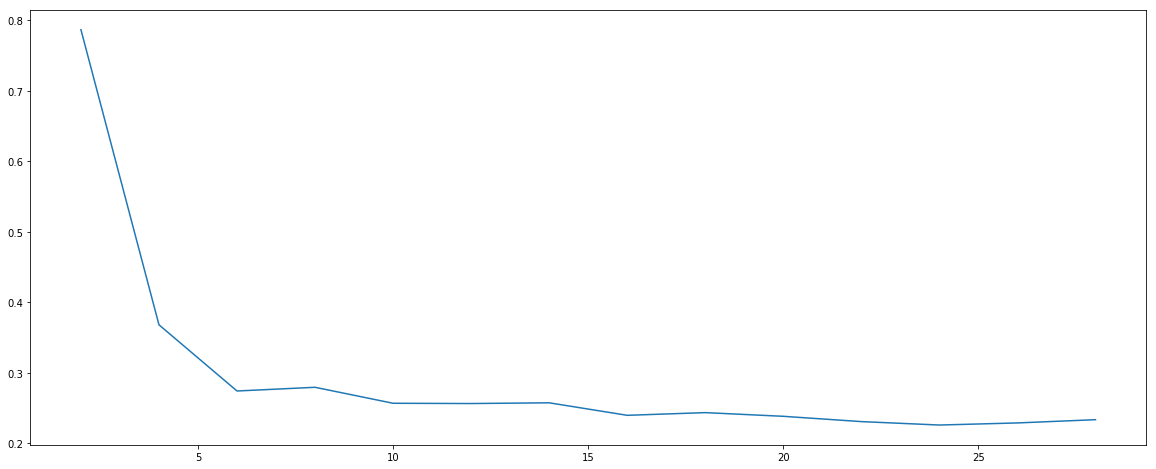

In [6]:
X = director

x = list(range(2, 30 , 2))
score = []
for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    score.append(silhouette_avg)
    
plt.figure(figsize=(20, 8))
plt.plot(x, score)
plt.legend()
plt.show()

In [7]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [19]:
model = UMAP(metric="euclidean", n_neighbors=15)
pos = model.fit_transform(X)

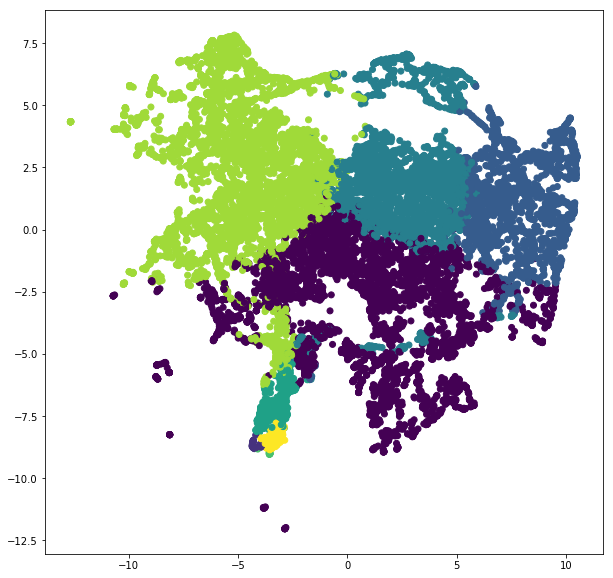

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(pos[:,0], pos[:,1], c=clusters)
plt.show()

In [21]:
director = pd.read_csv("../datas/prepared/final_director.csv", index_col = 0)
director["clusters"] = clusters
director.to_csv("../datas/prepared/final_director_with_clusters.csv", index=True)

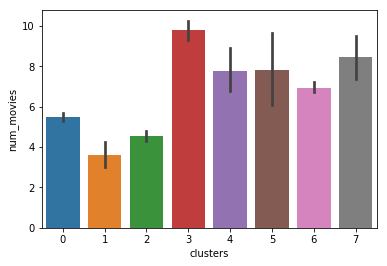

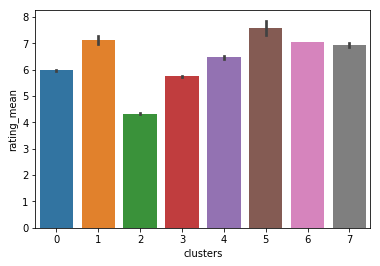

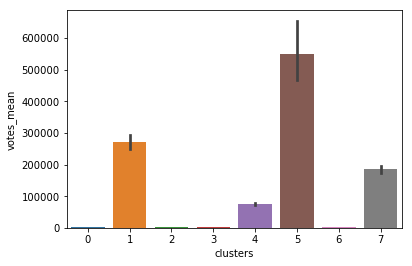

In [24]:
sns.barplot(x="clusters", y="num_movies", data=director)
plt.show()

sns.barplot(x="clusters", y="rating_mean", data=director)
plt.show()

sns.barplot(x="clusters", y="votes_mean", data=director)
plt.show()

We can see that based on votes, we also can find well known producer

In [22]:
director.head()

,num_movies,rating_min,rating_median,rating_max,rating_mean,rating_std,votes_min,votes_median,votes_max,votes_mean,votes_std,clusters
nconst,,,,,,,,,,,,
nm0000005,38,5.1,7.7,8.6,7.376316,0.801159,141,3818.0,130021,14083.473684,26431.025419,6
nm0000019,22,6.4,7.3,8.2,7.409091,0.531762,729,4832.5,91507,16004.090909,23071.775622,6
nm0000033,54,4.8,7.1,8.5,7.003704,0.886793,271,14754.5,488298,50657.222222,94882.031354,4
nm0000036,3,6.3,6.4,6.6,6.433333,0.152753,255,294.0,541,363.333333,155.094595,0
nm0000037,5,6.0,6.9,7.3,6.840000,0.512835,898,2137.0,11242,3743.000000,4321.703541,6


In [200]:
director.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15489 entries, nm0000005 to nm9179246
Data columns (total 11 columns):
num_movies       15489 non-null int64
rating_min       15489 non-null float64
rating_median    15489 non-null float64
rating_max       15489 non-null float64
rating_mean      15489 non-null float64
rating_std       15489 non-null float64
votes_min        15489 non-null int64
votes_median     15489 non-null float64
votes_max        15489 non-null int64
votes_mean       15489 non-null float64
votes_std        15489 non-null float64
dtypes: float64(8), int64(3)
memory usage: 1.4+ MB


# Writer

In [47]:
writer = principal[principal.category == "writer"]

In [48]:
writer = pd.merge(writer.reset_index(), title[['averageRating','numVotes']].reset_index(), on="tconst", how='inner')

In [49]:
writer = writer.groupby("nconst").agg({
    "tconst" : "nunique",
    "averageRating" : ["min", "median", "max", "mean", "std"],
    "numVotes" : ["min", "median", "max", "mean", "std"]
})

writer.fillna(0, inplace=True)
writer.columns = ["num_movies", "rating_min", "rating_median", "rating_max", "rating_mean", "rating_std", "votes_min", "votes_median", "votes_max", "votes_mean", "votes_std"]

In [62]:
writer = writer[writer.num_movies > 1]
writer = writer[writer.votes_max>500]

In [63]:
writer.to_csv("../datas/prepared/final_writer.csv", index=True)

In [64]:
writer = pd.read_csv("../datas/prepared/final_writer.csv", index_col = 0)

writer["num_movies"] = MinMaxScaler().fit_transform(writer[["num_movies"]])

writer["rating_min"] = StandardScaler().fit_transform(writer[["rating_min"]])
writer["rating_median"] = StandardScaler().fit_transform(writer[["rating_median"]])
writer["rating_max"] = StandardScaler().fit_transform(writer[["rating_max"]])
writer["rating_mean"] = StandardScaler().fit_transform(writer[["rating_mean"]])
writer["rating_std"] = StandardScaler().fit_transform(writer[["rating_std"]])

writer["votes_min"] = StandardScaler().fit_transform(writer[["votes_min"]])
writer["votes_median"] = StandardScaler().fit_transform(writer[["votes_median"]])
writer["votes_max"] = StandardScaler().fit_transform(writer[["votes_max"]])
writer["votes_mean"] = StandardScaler().fit_transform(writer[["votes_mean"]])
writer["votes_std"] = StandardScaler().fit_transform(writer[["votes_std"]])

N clusters = 2 Silhouette Score : 0.680121465742
N clusters = 4 Silhouette Score : 0.356131504353
N clusters = 6 Silhouette Score : 0.265579166405
N clusters = 8 Silhouette Score : 0.259508551278
N clusters = 10 Silhouette Score : 0.237346834611
N clusters = 12 Silhouette Score : 0.234606546602
N clusters = 14 Silhouette Score : 0.236870589957
N clusters = 16 Silhouette Score : 0.231753989491
N clusters = 18 Silhouette Score : 0.223377482883
N clusters = 20 Silhouette Score : 0.227964845568
N clusters = 22 Silhouette Score : 0.218829317776
N clusters = 24 Silhouette Score : 0.217638917641
N clusters = 26 Silhouette Score : 0.217655232744
N clusters = 28 Silhouette Score : 0.218442048314


C:\python36\envs\machine_learning\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


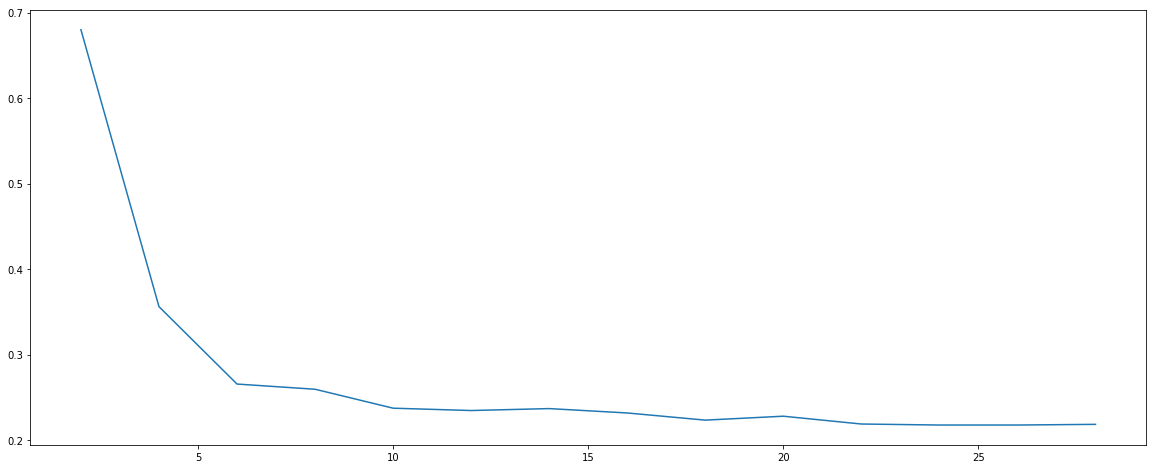

In [65]:
X = writer

x = list(range(2, 30 , 2))
score = []
for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    score.append(silhouette_avg)
    
plt.figure(figsize=(20, 8))
plt.plot(x, score)
plt.legend()
plt.show()

In [66]:
kmeans = KMeans(init='k-means++', n_clusters = 8, n_init=30)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [67]:
model = UMAP(metric="euclidean", n_neighbors=15)
pos = model.fit_transform(X)

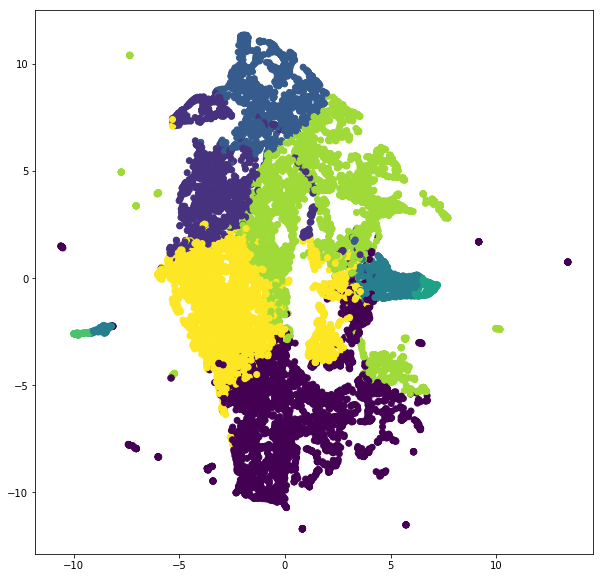

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(pos[:,0], pos[:,1], c=clusters)
plt.show()

In [69]:
writer = pd.read_csv("../datas/prepared/final_writer.csv", index_col = 0)
writer["clusters"] = clusters
writer.to_csv("../datas/prepared/final_writer_with_clusters.csv", index=True)

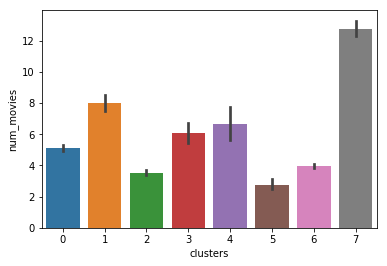

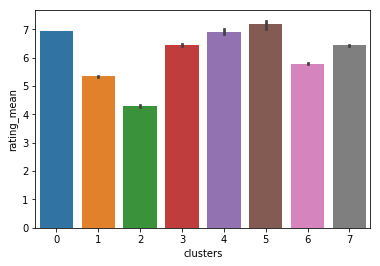

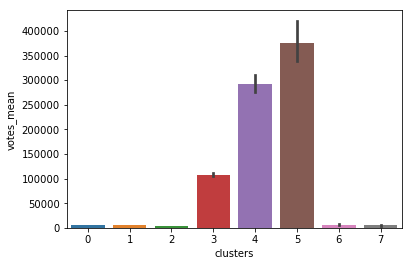

In [70]:
sns.barplot(x="clusters", y="num_movies", data=writer)
plt.show()

sns.barplot(x="clusters", y="rating_mean", data=writer)
plt.show()

sns.barplot(x="clusters", y="votes_mean", data=writer)
plt.show()

In [71]:
writer.head()

,num_movies,rating_min,rating_median,rating_max,rating_mean,rating_std,votes_min,votes_median,votes_max,votes_mean,votes_std,clusters
nconst,,,,,,,,,,,,
nm0000005,12,5.7,6.65,7.9,6.816667,0.697832,36,151.0,2967,826.083333,1144.483644,0
nm0000019,23,4.6,6.90,8.1,6.813043,0.718777,12,79.0,18759,1431.521739,4046.670100,7
nm0000036,8,5.2,6.80,8.0,6.612500,0.813173,8,771.5,27114,4814.250000,9219.997238,7
nm0000041,38,6.1,7.20,8.8,7.178947,0.632096,9,55.0,150018,8053.000000,27835.688900,0
nm0000076,7,5.2,6.30,7.9,6.600000,1.011599,17,1545.0,59480,10059.714286,21938.390945,7


In [72]:
writer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14875 entries, nm0000005 to nm9610722
Data columns (total 12 columns):
num_movies       14875 non-null int64
rating_min       14875 non-null float64
rating_median    14875 non-null float64
rating_max       14875 non-null float64
rating_mean      14875 non-null float64
rating_std       14875 non-null float64
votes_min        14875 non-null int64
votes_median     14875 non-null float64
votes_max        14875 non-null int64
votes_mean       14875 non-null float64
votes_std        14875 non-null float64
clusters         14875 non-null int32
dtypes: float64(8), int32(1), int64(3)
memory usage: 2.0+ MB
